# OpenVINO - get started
PyData Warsaw #30 - 1.10.2025 \
Presented by: Mikołaj Roszczyk (Intel)

## Install the requirements

In [ ]:
! pip install openvino torch torchvision matplotlib nncf

In [2]:
from take_path import get_path
CURRENT_DIR = get_path()

## Acquire the model and convert to OpenVINO

### Downloading a model

In [3]:
import torchvision
import torch

In [4]:
pytorch_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
pytorch_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Converting the model to OpenVINO

In [5]:
import openvino as ov

In [6]:
ov_model = ov.convert_model(pytorch_model)
ov.save_model(ov_model, CURRENT_DIR / "ov_model/resnet.xml")

### Preparing the input image

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
from take_path import get_path
IMAGE_PATH = CURRENT_DIR / "assets/mruczyslaw.jpg"

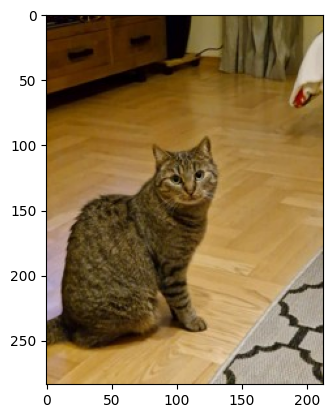

In [9]:
img = Image.open(IMAGE_PATH)
plt.imshow(img)

In [10]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = preprocess(img).unsqueeze(0)

### Running the OpenVINO model

In [ ]:
core = ov.Core()
ov_model = core.read_model(CURRENT_DIR / "ov_model/resnet.xml")

In [12]:
# let's check available deviced and compile the model
devices = core.get_available_devices()
print(devices)

['CPU', 'GPU']


In [13]:
# compile the model for the specific device or AUTO
compiled_model = core.compile_model(ov_model, "AUTO")

In [14]:
results = compiled_model(input_tensor)
print(results)

{<ConstOutput: names[x.45] shape[?,1000] type: f32>: array([[-6.67762220e-01, -1.18425250e+00, -3.50579000e+00,
        -2.22235560e+00, -1.56481528e+00, -1.26979852e+00,
        -4.04753160e+00, -1.64562094e+00, -1.01996589e+00,
        -2.57159686e+00, -1.58601892e+00, -4.32479715e+00,
        -9.00850773e-01, -3.54378390e+00, -3.38100076e+00,
         6.96376935e-02, -3.01095700e+00, -4.74423361e+00,
        -1.82956123e+00, -4.86451054e+00, -1.14612079e+00,
        -2.13343191e+00, -3.09579229e+00, -2.69054365e+00,
        -2.52882183e-01, -2.13964987e+00, -2.33353400e+00,
        -2.37754488e+00, -1.78487802e+00, -1.23316133e+00,
         4.12310719e-01, -2.36371136e+00, -1.22922100e-01,
        -2.27675486e+00, -6.10824168e-01, -1.10429570e-01,
         4.51404512e-01, -1.11709416e+00, -3.85827005e-01,
        -2.80103564e-01, -1.56020355e+00,  2.63889104e-01,
        -2.20613384e+00,  5.15204072e-01, -7.08706975e-01,
        -1.67480874e+00, -1.74079621e+00, -4.38696235e-01,
   

### Postprocess the output

In [15]:
chosen_class = results[0].argmax()
print(chosen_class)

281


In [16]:
categories = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.meta["categories"]
print(categories[chosen_class])

tabby


## Benchmarking

### Benchmark PyTorch vs OpenVINO

In [17]:
from time import time
ITERATIONS = 40

In [18]:
# PyTorch
pytorch_model(input_tensor)
begin = time()
for i in range(ITERATIONS):
    pytorch_model(input_tensor)
end = time()
average_time_pt = (end - begin) / ITERATIONS
fps_pt = 1 / average_time_pt
print(f"PyTorch Average time: {round(average_time_pt,5)}s FPS: {round(fps_pt,2)}")

PyTorch Average time: 0.10126s FPS: 9.88


In [19]:
# OpenVINO
compiled_model(input_tensor)
begin = time()
for i in range(ITERATIONS):
    compiled_model(input_tensor)
end = time()
average_time_ov = (end - begin) / ITERATIONS
fps_ov = 1 / average_time_ov
print(f"OpenVINO Average time: {round(average_time_ov,5)}s FPS: {round(fps_ov,2)}")

OpenVINO Average time: 0.11874s FPS: 8.42


### Can we optimize more? - quantization

In [20]:
import nncf

In [21]:
# get calibration dataset

def transform_fn(data_item):
    images, labels = data_item
    return images.numpy()

calibration_dataset_torch = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=preprocess)
calib_loader_torch = torch.utils.data.DataLoader(calibration_dataset_torch, batch_size=32, shuffle=False)
calibration_dataset_nncf = nncf.Dataset(calib_loader_torch, transform_func=transform_fn)

In [ ]:
quantized_model = nncf.quantize(ov_model, calibration_dataset_nncf)

In [23]:
ov.save_model(quantized_model, CURRENT_DIR / "ov_model/quantized.xml")

In [24]:
compiled_model_quantized = core.compile_model(quantized_model, "AUTO")

In [25]:
quantized_result = compiled_model_quantized(input_tensor)
quantized_predicted_class = quantized_result[0].argmax()
print(categories[quantized_predicted_class])

tabby


In [26]:
# OpenVINO quantized
compiled_model_quantized(input_tensor)
begin = time()
for i in range(ITERATIONS):
    compiled_model_quantized(input_tensor)
end = time()
average_time_ov = (end - begin) / ITERATIONS
fps_ov = 1 / average_time_ov
print(f"OpenVINO Average time: {round(average_time_ov,5)}s FPS: {round(fps_ov,2)}")

OpenVINO Average time: 0.0107s FPS: 93.43


## Integrated to Ultralytics YOLO

In [ ]:
! pip install ultralytics opencv-python

In [28]:
import cv2
from ultralytics import YOLO
from time import time

In [ ]:
model = YOLO("yolov8n.pt")
cap = cv2.VideoCapture(0)
times_pytorch = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    begin = time()
    results = model(frame)
    end = time()
    times_pytorch.append(end-begin)
    annotated_frame = results[0].plot()
    cv2.imshow("YOLOv8 Webcam", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [36]:
times_pytorch.pop(0)
average_time_pt = sum(times_pytorch) / len(times_pytorch)
fps_pt = 1 / average_time_pt
print(f"PyTorch Average time: {round(average_time_pt,5)}s FPS: {round(fps_pt,2)}")

PyTorch Average time: 0.07866s FPS: 12.71


In [ ]:
model = YOLO("yolov8n.pt")
model.export(format="openvino")

ov_model = YOLO(CURRENT_DIR / "yolov8n_openvino_model")

cap = cv2.VideoCapture(0)
times_ov = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    begin = time()
    results = ov_model.predict(frame, device="intel:cpu")
    end = time()
    times_ov.append(end-begin)
    annotated_frame = results[0].plot()
    cv2.imshow("YOLOv8 Webcam", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [32]:
times_ov.pop(0)
average_time_ov = sum(times_ov) / len(times_ov)
fps_ov = 1 / average_time_ov
print(f"OpenVINO Average time: {round(average_time_ov,5)}s FPS: {round(fps_ov,2)}")

OpenVINO Average time: 0.0444s FPS: 22.52


In [ ]:
import shutil
shutil.copy(CURRENT_DIR / "yolov8n.pt", CURRENT_DIR / "yolov8n_copy.pt")

In [ ]:
model = YOLO("yolov8n_copy.pt")
model.export(format="openvino", int8=True)

ov_model = YOLO(CURRENT_DIR / "yolov8n_copy_int8_openvino_model")

cap = cv2.VideoCapture(0)
times_ov = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    begin = time()
    results = ov_model.predict(frame, device="intel:cpu")
    end = time()
    times_ov.append(end-begin)
    annotated_frame = results[0].plot()
    cv2.imshow("YOLOv8 Webcam", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [35]:
times_ov.pop(0)
average_time_ov = sum(times_ov) / len(times_ov)
fps_ov = 1 / average_time_ov
print(f"OpenVINO FP16 Average time: {round(average_time_ov,5)}s FPS: {round(fps_ov,2)}")

OpenVINO FP16 Average time: 0.02656s FPS: 37.65
